# Feed Forward Networks

In [1]:
# Built-in library
import logging
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 2_000

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import (
    set_up_logger,
    create_iris_data,
    create_qwerties_data,
    smooth,
)
from src.data_manager import (
    load_data,
    create_data_loader,
    split_into_train_n_validation,
)
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

## Build A FFN That Can Be Used To Add Two Numbers

In [2]:
# Create training data
(LOW, HIGH) = (-20, 21)
SIZE, SEED = (5000, 2), 123

np.random.seed(SEED)
X = np.random.randint(low=LOW, high=HIGH, size=SIZE)

X[:5]

array([[-18,   8],
       [ 14,  18],
       [ -3,  -1],
       [  2,  13],
       [ 12, -11]])

In [3]:
# Target variable
y = np.sum(X, axis=1)
y = pd.Series(y)
y.head()

0   -10
1    32
2    -4
3    15
4     1
dtype: int64

In [4]:
# Normalize the data
normalizer = Normalizer()
X_norm = normalizer.fit_transform(X)

# Convert to Tensor
X_norm = torch.Tensor(X_norm)
X_norm = pd.DataFrame(X_norm)

X_norm.describe()

,0,1
count,5000.000000,5000.000000
mean,0.495200,0.501205
std,0.294649,0.294064
min,0.000000,0.000000
25%,0.250000,0.250000
50%,0.500000,0.500000
75%,0.750000,0.750000
max,1.000000,1.000000


In [5]:
# Split data
TEST_SIZE, RANDOM_STATE = 0.2, 123
X_train, X_validation, y_train, y_validation = train_test_split(
    X_norm, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

((4000, 2), (1000, 2))

In [6]:
from src.data_manager import _create_torch_dataset

X_train = torch.Tensor(X_train.to_numpy())
X_validation = torch.Tensor(X_validation.to_numpy())
y_train = torch.Tensor(y_train.to_numpy()).reshape(-1, 1)
y_validation = torch.Tensor(y_validation.to_numpy()).reshape(-1, 1)


# Create Torch Dataloader
BATCH_SIZE = 16
train_DL, validation_DL = create_data_loader(
    X_train=X_train,
    X_validation=X_validation,
    y_train=y_train,
    y_validation=y_validation,
    batch_size=BATCH_SIZE,
)

In [7]:
train_DL.dataset.tensors[0].shape, train_DL.dataset.tensors[1].shape,

(torch.Size([4000, 2]), torch.Size([4000, 1]))

In [8]:
# Build and train model
class Net(nn.Module):
    """This is used to build the FFN architecture for adding up numbers."""

    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(2, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used for forward propagation."""
        X = F.relu(self.input(X))
        X = self.output(X)
        return X


def train_FFN_model(
    *,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    epochs: int,
    lr: float,
) -> tuple[torch.Tensor, torch.Tensor, Net]:
    """This is used to train the FFN model"""
    net = Net()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)
    train_loss, validation_loss = (
        torch.zeros(size=(epochs,)),
        torch.zeros(size=(epochs,)),
    )

    for epoch_idx in np.arange(epochs):
        net.train()
        batch_loss = []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()
            # Forward prop
            y_pred = net(X_)
            loss = criterion(y_pred, y_)

            # Back prop
            loss.backward()
            optimizer.step()

            # Batch loss
            batch_loss.append(loss.detach())

        # Train Loss
        train_loss[epoch_idx] = np.mean(batch_loss, dtype="float64")

        # Validation loss
        net.eval()
        X_val, y_val = next(iter(validation_dataloader))
        y_pred_ = net(X_val)
        val_loss = criterion(y_pred_, y_val)
        validation_loss[epoch_idx] = val_loss.detach()

    return train_loss, validation_loss, net

In [9]:
EPOCHS, LR = 50, 0.01

train_loss, validation_loss, trained_net = train_FFN_model(
    train_dataloader=train_DL, validation_dataloader=validation_DL, epochs=EPOCHS, lr=LR
)

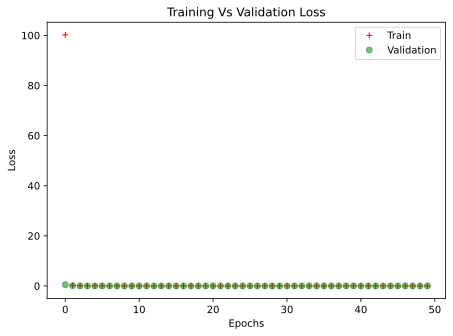

In [10]:
# Visualize the results.
plt.plot(train_loss, "r+", alpha=1, label="Train")
plt.plot(validation_loss, "go", alpha=0.5, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Vs Validation Loss")
plt.legend(loc=0)

plt.tight_layout()
plt.show()

In [11]:
# Create Test Data
torch.manual_seed(SEED)
test_data_original = torch.randint(-20, 20, size=(500, 2)).float()

# Normalize and convert to float32
test_data = normalizer.transform(X=test_data_original).float()

test_data[:5], test_data.dtype, test_data_original.dtype

(tensor([[0.5500, 0.7250],
         [0.5500, 0.2500],
         [0.5000, 0.0500],
         [0.1500, 0.4250],
         [0.4750, 0.8500]]),
 torch.float32,
 torch.float32)

In [12]:
test_data_original[:5]

tensor([[  2.,   9.],
        [  2., -10.],
        [  0., -18.],
        [-14.,  -3.],
        [ -1.,  14.]])

In [13]:
# Make predictions using the trained model
predictions = trained_net(test_data).reshape(-1).detach()
predictions[:5]

tensor([ 10.9792,  -7.9958, -17.9820, -16.9791,  12.9775])

In [14]:
d_ = {
    "x1": test_data_original[:, 0],
    "x2": test_data_original[:, 1],
    "y_true": torch.sum(test_data_original, dim=1),
    "y_pred": np.round(predictions, 1),
}
pd.DataFrame(d_).head(10)

,x1,x2,y_true,y_pred
0,2.0,9.0,11.0,11.0
1,2.0,-10.0,-8.0,-8.0
2,0.0,-18.0,-18.0,-18.0
3,-14.0,-3.0,-17.0,-17.0
4,-1.0,14.0,13.0,13.0
5,-9.0,-19.0,-28.0,-28.0
6,-14.0,-19.0,-33.0,-33.0
7,12.0,-11.0,1.0,1.0
8,-6.0,11.0,5.0,5.0
9,13.0,-20.0,-7.0,-7.0


<hr><br><br>

## Predict Presence of Heart Disease

```text
Data information:
- https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Data source
- https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
```

In [15]:
fp = "../../data/processed.cleveland.csv"
col_names = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "severity",
]
heart_dis_data = load_data(filename=fp)
heart_dis_data.columns = col_names

heart_dis_data.head()

Shape of data: (302, 14)



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,severity
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


#### Preprocess The Data

In [16]:
# Target
heart_dis_data["severity"].value_counts(normalize=True)

severity
0    0.539735
1    0.182119
2    0.119205
3    0.115894
4    0.043046
Name: proportion, dtype: float64

In [17]:
# Binarize the target
THRESH = 0
heart_dis_data["target"] = np.where(heart_dis_data["severity"] > THRESH, 1, 0)

heart_dis_data["target"].value_counts(normalize=True)

target
0    0.539735
1    0.460265
Name: proportion, dtype: float64

In [18]:
heart_dis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   cp        302 non-null    float64
 3   trestbps  302 non-null    float64
 4   chol      302 non-null    float64
 5   fbs       302 non-null    float64
 6   restecg   302 non-null    float64
 7   thalach   302 non-null    float64
 8   exang     302 non-null    float64
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    float64
 11  ca        302 non-null    object 
 12  thal      302 non-null    object 
 13  severity  302 non-null    int64  
 14  target    302 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.5+ KB


In [19]:
num_vars = list(heart_dis_data.select_dtypes(include=[int, float]).columns)
cat_vars = list(heart_dis_data.select_dtypes(include=["object"]).columns)

len(num_vars), len(cat_vars)

(13, 2)

In [20]:
heart_dis_data[num_vars].isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
severity    0
target      0
dtype: int64

In [21]:
heart_dis_data[cat_vars].isna().sum()

ca      0
thal    0
dtype: int64

In [22]:
heart_dis_data[cat_vars].apply(lambda x: pd.Series.value_counts(x, normalize=True))

,ca,thal
0.0,0.579470,NaN
1.0,0.215232,NaN
2.0,0.125828,NaN
3.0,0.066225,0.549669
6.0,NaN,0.056291
7.0,NaN,0.387417
?,0.013245,0.006623


In [23]:
# Replace "?" with the most occurring value
value = "?"
for var in cat_vars:
    most_freq = heart_dis_data[var].value_counts().index[0]
    heart_dis_data[var] = heart_dis_data[var].replace(value, most_freq)

In [24]:
# Validate the step above
heart_dis_data[cat_vars].apply(lambda x: pd.Series.value_counts(x, normalize=True))

,ca,thal
0.0,0.592715,NaN
1.0,0.215232,NaN
2.0,0.125828,NaN
3.0,0.066225,0.556291
6.0,NaN,0.056291
7.0,NaN,0.387417


In [25]:
# Convert to numeric data
heart_dis_data[cat_vars] = heart_dis_data[cat_vars].astype(float)

In [26]:
heart_dis_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,severity,target
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.410596,0.678808,3.165563,131.645695,246.738411,0.145695,0.986755,149.605960,0.327815,1.035430,1.596026,0.665563,4.718543,0.940397,0.460265
std,9.040163,0.467709,0.953612,17.612202,51.856829,0.353386,0.994916,22.912959,0.470196,1.160723,0.611939,0.935142,1.940199,1.229384,0.499246
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
50%,55.500000,1.000000,3.000000,130.000000,241.500000,0.000000,0.500000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,1.000000


In [27]:
# Normalize data
normalizer = Normalizer()
X_norm = normalizer.fit_transform(X=heart_dis_data.loc[:, "age":"thal"])
X_norm.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.791667,1.0,1.000000,0.622642,0.365297,0.0,1.0,0.282443,1.0,0.241935,0.5,1.000000,0.0
1,0.791667,1.0,1.000000,0.245283,0.235160,0.0,1.0,0.442748,1.0,0.419355,0.5,0.666667,1.0
2,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.0,0.885496,0.0,0.564516,1.0,0.000000,0.0
3,0.250000,0.0,0.333333,0.339623,0.178082,0.0,1.0,0.770992,0.0,0.225806,0.0,0.000000,0.0
4,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.0,0.816794,0.0,0.129032,0.0,0.000000,0.0


In [28]:
# Split data
y = heart_dis_data["target"]
TEST_SIZE, RANDOM_STATE = 0.2, 123
X_train, X_validation, y_train, y_validation = train_test_split(
    X_norm, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

((241, 13), (61, 13))

In [29]:
X_train = torch.Tensor(X_train.to_numpy())
X_validation = torch.Tensor(X_validation.to_numpy())
y_train = torch.Tensor(y_train.to_numpy()).reshape(-1, 1)
y_validation = torch.Tensor(y_validation.to_numpy()).reshape(-1, 1)


# Create Torch Dataloader
BATCH_SIZE = 16
train_DL, validation_DL = create_data_loader(
    X_train=X_train,
    X_validation=X_validation,
    y_train=y_train,
    y_validation=y_validation,
    batch_size=BATCH_SIZE,
)

In [30]:
# Build and train model
class Net(nn.Module):
    """This is used to build the FFN architecture for detecting the
    presence of hear diseases."""

    def __init__(self) -> None:
        super().__init__()
        self.input = nn.Linear(13, 64)
        self.hidden_1 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used for forward propagation."""
        X = F.relu(self.input(X))
        X = F.relu(self.hidden_1(X))
        X = torch.sigmoid(self.output(X))
        return X


def train_FFN_model(
    *,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    epochs: int,
    lr: float,
) -> tuple[torch.Tensor, torch.Tensor, Net]:
    """This is used to train the FFN model"""
    net = Net()
    THRESH, PCT = 0.5, 100
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)
    train_accuracy, validation_accuracy, train_loss = (
        torch.zeros(size=(epochs,)),
        torch.zeros(size=(epochs,)),
        torch.zeros(size=(epochs,)),
    )

    for epoch_idx in np.arange(epochs):
        net.train()
        batch_accuracy, batch_loss = [], []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()
            # Forward prop
            y_proba = net(X_)
            loss = criterion(y_proba, y_)
            acc = torch.mean(((y_proba > THRESH) == y_).float()) * PCT

            # Back prop
            loss.backward()
            optimizer.step()

            # Batch loss and accuracy
            batch_loss.append(loss.detach())
            batch_accuracy.append(acc.detach())

        # Train Loss and accuracy
        train_loss[epoch_idx] = np.mean(batch_loss, dtype="float64")
        train_accuracy[epoch_idx] = np.mean(batch_accuracy, dtype="float64")

        # Validation loss
        net.eval()
        X_val, y_val = next(iter(validation_dataloader))
        y_proba_ = net(X_val)
        acc_ = torch.mean(((y_proba_ > THRESH) == y_val).float()) * PCT
        validation_accuracy[epoch_idx] = acc_.detach()

    return (train_accuracy, validation_accuracy, train_loss, net)

In [32]:
EPOCHS, LR = 300, 0.001

train_accuracy, validation_accuracy, train_loss, trained_net = train_FFN_model(
    train_dataloader=train_DL, validation_dataloader=validation_DL, epochs=EPOCHS, lr=LR
)

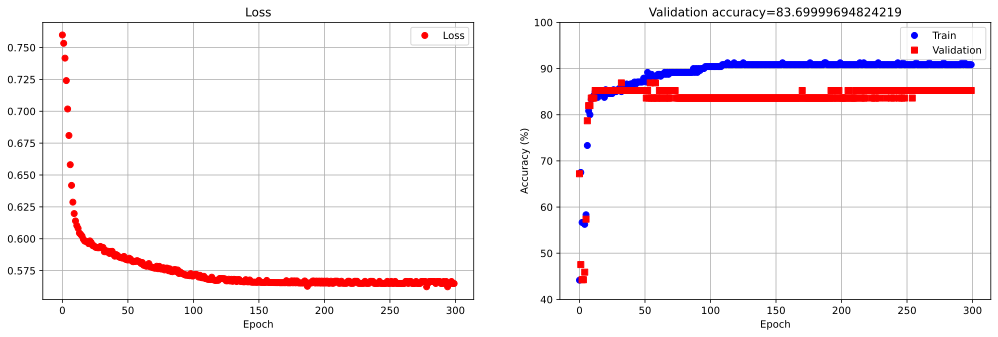

In [33]:
val_accuracy = np.mean(validation_accuracy.numpy()).round(1)

# Visualize the results.
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(train_loss, "ro", label="Loss")
ax[0].set_title("Loss")

ax[1].plot(train_accuracy, "bo", label="Train")
ax[1].plot(validation_accuracy, "rs", label="Validation")
ax[1].set_title(f"Validation accuracy={val_accuracy}")

# Common features
for idx in range(2):
    ax[idx].legend(loc="best")
    ax[idx].set_xlabel("Epoch")
    if idx > 0:
        ax[idx].set_ylabel("Accuracy (%)")
        ax[idx].set_ylim(40, 100)
    ax[idx].grid()

plt.show()